In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as sg
from imutils import contours
import imutils
import glob
import os
import pandas as pd
import decimal

In [2]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(16, 5)})

## Which video results to open? Either Video 1 or Video 2.

In [3]:
VIDEO_NUMBER = 2

In [4]:
if VIDEO_NUMBER == 1:
    results_output_path = "./out/protoshape/video1/processed_video/"
elif VIDEO_NUMBER == 2:
    results_output_path = "./out/protoshape/video2/processed_video/"

## Load DataFrame from CSV file.

In [5]:
df = pd.read_csv(results_output_path + "pool_data_from_video.csv") 

In [6]:
df.head()

,Frame_Index,Area,Mean,Radius,Rotated_Box
0,frame_0006820.png,0.0,0.0,0.0,NaN
1,frame_0006821.png,0.0,0.0,0.0,NaN
2,frame_0006822.png,0.0,0.0,0.0,NaN
3,frame_0006823.png,0.0,0.0,0.0,NaN
4,frame_0006824.png,0.0,0.0,0.0,NaN


## Visualisations

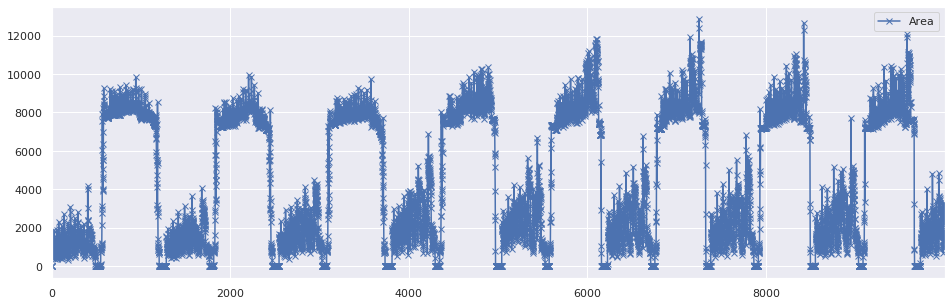

In [7]:
cols = ['Area']
df[cols].iloc[:10000].plot(marker='x')

### Rolling average of area

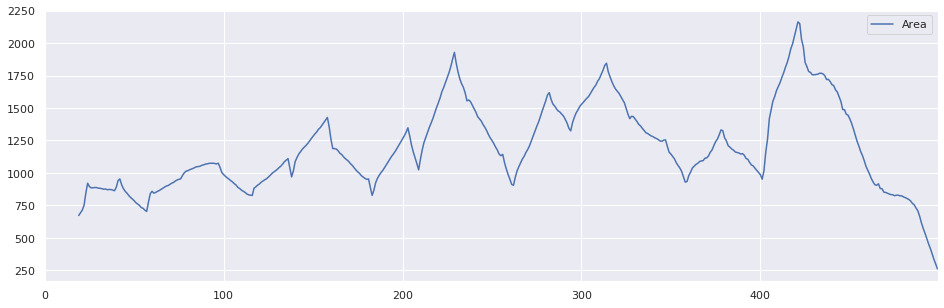

In [8]:
cols = ['Area']
#df[cols][df['Area'] != 0].rolling(20).mean().plot()
df[cols].iloc[:500].rolling(20).mean().plot()

## Remove Artifacts (remove frames where powder depositor is in frame)

If area > threshold, ignore frame and ignore everything -50 and ignore all frames + 50.

In [9]:
area = df['Area']
frames = df.index

In [10]:
area

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
359324    0.0
359325    0.0
359326    0.0
359327    0.0
359328    0.0
Name: Area, Length: 359329, dtype: float64

In [11]:
# Compute threshold - average of non-zero
area_threshold = area.replace(0, np.nan).mean(skipna=True)

In [12]:
area_threshold

7845.552475802082

Scale threshold by a factor

In [27]:
SCALE_FACTOR = 0.6

In [28]:
area_under_thresh = area.where(area < area_threshold * SCALE_FACTOR)

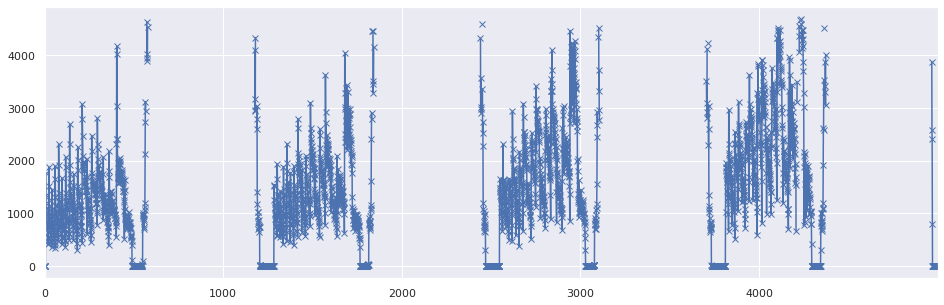

In [29]:
area_under_thresh.iloc[:5000].plot(marker='x')

Remove the neighbouring values around threshold

In [53]:
len(area_under_thresh.loc[area_under_thresh.isna()])

221978

In [58]:
area_under_thresh.loc[area_under_thresh.isna()]

566      NaN
567      NaN
568      NaN
569      NaN
570      NaN
          ..
308440   NaN
308441   NaN
308442   NaN
308443   NaN
308444   NaN
Name: Area, Length: 221978, dtype: float64

In [ ]:
df.fillna(method='pad', limit=1)

In [121]:
mylist = [1,2,3,3,2,4,None,None,3,2,4,5,None,None,None,None,None,3,2,1,3,None,None,4,2,1,3,4]
ex = pd.DataFrame(mylist)
ex.columns = ['value']
ex = ex['value']
print(ex)

0     1.0
1     2.0
2     3.0
3     3.0
4     2.0
5     4.0
6     NaN
7     NaN
8     3.0
9     2.0
10    4.0
11    5.0
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    3.0
18    2.0
19    1.0
20    3.0
21    NaN
22    NaN
23    4.0
24    2.0
25    1.0
26    3.0
27    4.0
Name: value, dtype: float64


In [137]:
ex.loc[ex.isna()]

6    NaN
7    NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
21   NaN
22   NaN
Name: value, dtype: float64

In [147]:
index_of_NaNs = ex.loc[ex.isna()].index
print(index_of_NaNs)

Int64Index([6, 7, 12, 13, 14, 15, 16, 21, 22], dtype='int64')


In [143]:
shifted_indexes_left = ex.loc[ex.isna()].index - 2
print(shifted_indexes)

Int64Index([4, 5, 10, 11, 12, 13, 14, 19, 20], dtype='int64')


In [149]:
pd.IntervalIndex.from_arrays(shifted_indexes_left,index_of_NaNs)

IntervalIndex([(4, 6], (5, 7], (10, 12], (11, 13], (12, 14], (13, 15], (14, 16], (19, 21], (20, 22]],
              closed='right',
              dtype='interval[int64]')

In [144]:
ex[shifted_indexes_left]

4     2.0
5     4.0
10    4.0
11    5.0
12    NaN
13    NaN
14    NaN
19    1.0
20    3.0
Name: value, dtype: float64

In [140]:
area_under_thresh.notnull()

0         True
1         True
2         True
3         True
4         True
          ... 
359324    True
359325    True
359326    True
359327    True
359328    True
Name: Area, Length: 359329, dtype: bool

In [ ]:
area_under_thresh_clipped_neighbours = area_under_thresh.where( area_under_thresh.isna() )

In [ ]:
area_under_thresh_clipped_neighbours

In [ ]:
area_under_thresh_clipped_neighbours.isna().all()

### Low pass filtering by applying a weighted running mean over the time dimension.
(https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html)

### Linear filter
(https://ipython-books.github.io/102-applying-a-linear-filter-to-a-digital-signal/)

In [ ]:
area.head()

### FIR filter
Convolve signal with triangular window.

In [ ]:
# We get a triangular window with 60 samples.
h = sg.get_window('triang', 60)
# We convolve the signal with this window.
fil = sg.convolve(area, h / h.sum())
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# We plot the original signal...
area_under_thresh.iloc[:10000].plot(ax=ax, lw=3)
# ... and the filtered signal.
ax.plot(frames, fil[:len(area_under_thresh.iloc[:10000])], '-w', lw=2)

### IIR Butterworth low-pass filter

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
area_under_thresh.iloc[:5000].plot(ax=ax, lw=3)
# We create a 4-th order Butterworth low-pass filter.
b, a = sg.butter(4, 2. / 365)
# We apply this filter to the signal.
ax.plot(frames, sg.filtfilt(b, a, area_under_thresh.iloc[:5000]),'-w', lw=2)

### High-pass filter
To get fast variations.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
area_under_thresh.iloc[:5000].plot(ax=ax, lw=1)
b, a = sg.butter(4, 2 * 5. / 365, btype='high')
ax.plot(frames, sg.filtfilt(b, a, area_under_thresh.iloc[:5000]),'-', lw=1)